_Neural Data Science_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2022

Student names: *Yirong Xiong & Hanru Zhang*

# Coding Lab 2

If needed, download the data files ```nda_ex_1_*.npy``` from ILIAS and save it in the subfolder ```../data/```. Use a subset of the data for testing and debugging. But be careful not to make it too small, since the algorithm may fail to detect small clusters in this case. 

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy import signal
from sklearn.cluster import KMeans
import scipy as sp
from scipy.io import loadmat
import copy
from scipy import linalg
import time

sns.set_style('whitegrid')
%matplotlib inline

## Load data

In [6]:
# b = np.load('../data/nda_ex_1_featuresnpy.sec')
# s = np.load('../data/nda_ex_1_spiketimes_snpy.sec')
# w = np.load('../data/nda_ex_1_waveformsnpy.sec')

In [30]:
# replace by path to your solutions
b = np.load('../data/nda_ex_1_features.npy')
s = np.load('../data/nda_ex_1_spiketimes_s.npy')
w = np.load('../data/nda_ex_1_waveforms.npy')
np.random.seed(0)

## Task 1: Generate toy data

Sample 1000 data points from a two dimensional mixture of Gaussian model with three clusters  and the following parameters:

$\mu_1 = \begin{bmatrix}0\\0\end{bmatrix}, \Sigma_1 = \begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}, \pi_1=0.3$

$\mu_2 = \begin{bmatrix}5\\1\end{bmatrix}, \Sigma_2 = \begin{bmatrix}2 & 1\\1 & 2\end{bmatrix}, \pi_2=0.5$

$\mu_3 = \begin{bmatrix}0\\4\end{bmatrix}, \Sigma_3 = \begin{bmatrix}1 & -0.5\\-0.5 & 1\end{bmatrix}, \pi_3=0.2$

Plot the sampled data points and indicate in color the cluster each point came from. Plot the cluster means as well.

*Grading: 1 pts*


In [9]:
def sample_data(N, m, S, p):
    
    '''Generate N samples from a Mixture of Gaussian distribution with 
    means m, covariances S and priors p.
    
    Parameters
    ----------
    
    N: int
        Number of samples
    
    m: list or np.array, (n_clusters, n_dims)
        Means
    
    S: list or np.array, (n_clusters, n_dims, n_dims)
        Covariances
    
    p: list or np.array, (n_clusters, )
        Cluster weights / probablities
    
    Returns
    -------
    
    x: np.array, (n_samples, n_dims)
        Data points
    
    ind: np.array, (n_samples,)
        Labels.
    '''
    # insert your code here
    n_clusters,n_dims = m.shape
    labels = []
    x = np.empty((0,n_dims), dtype = float, order = 'C')
    for i in range(n_clusters):
        labels.append(np.repeat(i,int(N*p[i])))
        x = np.concatenate((x,np.random.multivariate_normal(m[i,:],S[i,:,:],int(N*p[i]),'warn')),axis=0)
    labels = np.concatenate(labels)
    # ------------------------------------------------------
    # draw labeled points from mixture of Gaussians (0.5 pt)
    # ------------------------------------------------------
    
    return (labels, x)    


In [10]:
N = 1000 # total number of samples
m = np.array([[0,0],[5,1],[0,4]])
S = np.array([[[1,0],[0,1]],[[2,1],[1,2]],[[1,-.5],[-.5,1]]])
p = np.array([.3,.5,.2])
# insert code here

labels, x = sample_data(N, m, S, p)

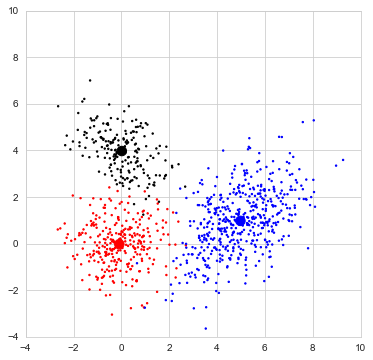

In [11]:
plt.figure(figsize=(6, 6))

# insert code here
colors = ['red','blue','black']
means = np.array([np.average(x[np.where(labels==label)[0],:],axis=0) for label in np.unique(labels)])

plt.scatter(x[:,0],x[:,1],c=[colors[i] for i in labels],s=2)
plt.scatter(means[:,0],means[:,1],c=colors,s=90)
plt.xlim((-4,10))
plt.ylim((-4,10))
plt.show()

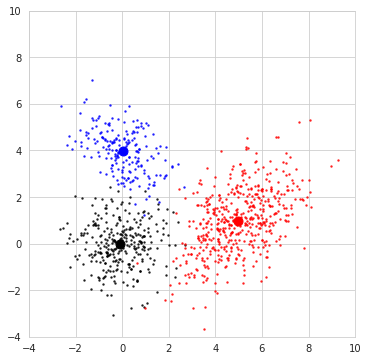

## Task 2: Implement a Gaussian mixture model

Implement the EM algorithm to fit a Gaussian mixture model in `fit_mog()`.  Sort the data points by inferring their class labels from your mixture model (by using maximum a-posteriori classification). Fix the seed of the random number generator to ensure deterministic and reproducible behavior. Test it on the toy dataset specifying the correct number of clusters and make sure the code works correctly. Plot the data points from the toy dataset and indicate in color the cluster each point was assigned to by your model. How does the assignment compare to ground truth? If you run the algorithm multiple times, you will notice that some solutions provide suboptimal clustering solutions - depending on your initialization strategy.  

*Grading: 4 pts*


In [12]:
def check_cov(cov):

    cov[np.isnan(cov)] = 0
    cov[np.isinf(cov)] = 0

    min_eig = np.min(np.real(np.linalg.eigvals(cov)))
    if min_eig <= 1e-6:
        cov += np.eye(len(cov))*(1e-6)
    return cov

In [13]:
def fit_mog(x,k, niters=10, random_seed=None,verbose=False):
    
    '''Fit Mixture of Gaussian model using EM algo.
    
    Parameters
    ----------
    
    x: np.array, (n_samples, n_dims)
        Input data
        
    k: int
        Number of clusters
        
    niters: int
        Maximal number of iterations.
        
    random_seed: int or None
        Random Seed
    
    
    Returns
    -------
    
    labels: np.array, (n_samples)
        Cluster labels
        
    m: list or np.array, (n_clusters, n_dims)
        Means
    
    S: list or np.array, (n_clusters, n_dims, n_dims)
        Covariances
    
    p: list or np.array, (n_clusters, )
        Cluster weights / probablities
    '''

    # fill in your code here
    
    np.random.seed(random_seed)
    
    D = x.shape[1]
    N = x.shape[0]
    
    # -----------
    # init (1 pt)
    # -----------
    
    kmeans = KMeans(n_clusters=k, random_state=np.random.RandomState()).fit(x)
    labels = kmeans.labels_
    m = np.array([np.average(x[np.where(labels==label)[0],:],axis=0) for label in range(k)])
    S = np.array([np.cov(x[np.where(labels==label)[0],:].T) for label in range(k)])
    p = np.array([len(np.where(labels==label)[0])/N for label in range(k)])
    post = np.zeros((N,k))
    log_likelihoods = []

    # -------------------------
    # EM maximisation (2.5 pts)
    # -------------------------
    while len(log_likelihoods) < niters:
        ## E step
        for label in range(k):
            S[label,:,:] = check_cov(S[label,:,:])
            post[:,label] = p[label]*sp.stats.multivariate_normal.pdf(x,m[label,:],S[label,:,:],allow_singular=True)
        post[np.isnan(post)] = 0
        post[np.isinf(post)] = 0
        log_likelihoods.append(np.mean(np.log(post.sum(axis=1))))
        post = np.divide(post,np.repeat(np.sum(post,axis=1),k).reshape((N,k)))
        
        ## M step
        labels = np.argmax(post, axis=1)
        p = np.array([len(np.where(labels==label)[0])/N for label in range(k)])
        p = np.where(p==0,1e-6,p)
        for label in range(k):
            m[label,:] = np.sum(np.multiply(np.repeat(post[:,label],D).reshape((N,D)),x),axis=0)/(p[label]*N)
            S[label,:,:] = np.dot((np.repeat(post[:,label],D).reshape((N,D))*(x-np.tile(m[label,:],(N,1)))).T,
                                  x-np.tile(m[label,:],(N,1)))/(p[label]*N)
        
        if verbose: print('Step %04d likelihood: %.2f'%(len(log_likelihoods),log_likelihoods[-1]))
        if len(log_likelihoods) < 2: continue
        if np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < 0.001: break
    
    
    return (labels, m, S, p)

Run Mixture of Gaussian on toy data

In [14]:
mog_labels, m, S, p = fit_mog(x,3, 10,random_seed=1,verbose=True)

Step 0001 likelihood: -4.04
Step 0002 likelihood: -4.03
Step 0003 likelihood: -4.03
Step 0004 likelihood: -4.02
Step 0005 likelihood: -4.02
Step 0006 likelihood: -4.02


Plot toy data with cluster assignments and compare to original labels

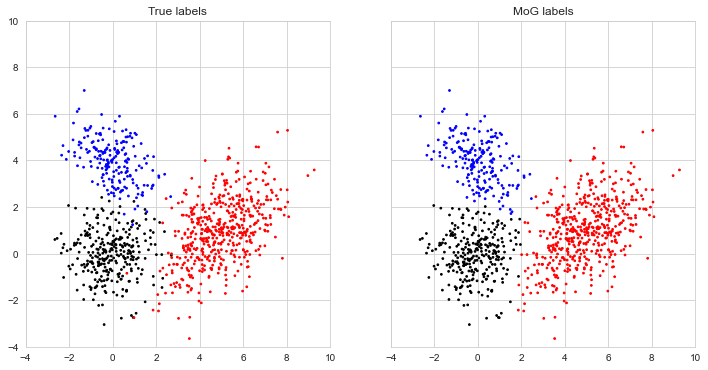

In [15]:
# plt.figure(figsize=(12, 6))

# ----------------------------------------------
# plot points from mixture of Gaussians (0.5 pt)
# ----------------------------------------------
fig, axs = plt.subplots(1,2,figsize=(12, 6),sharey='row',sharex='row')
colors = ['black','red','blue']
means = np.array([np.average(x[np.where(labels==label)[0],:],axis=0) for label in np.unique(labels)])
axs[0].scatter(x[:,0],x[:,1],c=[colors[i] for i in labels],s=3)
#axs[0].scatter(means[:,0],means[:,1],c=colors,s=100)
axs[0].set_xlim((-4,10))
axs[0].set_ylim((-4,10))
axs[0].set_title('True labels')


axs[1].scatter(x[:,0],x[:,1],c=[colors[i] for i in mog_labels],s=3)
#axs[1].scatter(m[:,0],m[:,1],c=colors,s=100)
axs[1].set_xlim((-4,10))
axs[1].set_ylim((-4,10))
axs[1].set_title('MoG labels')
plt.show()


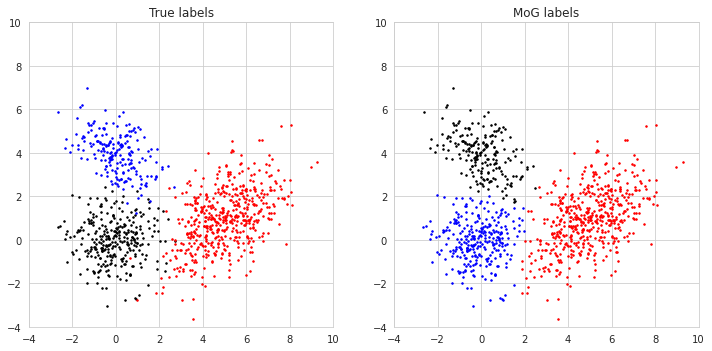

## Task 3: Model complexity
A priori we do not know how many neurons we recorded. Extend your algorithm with an automatic procedure to select the appropriate number of mixture components (clusters). Base your decision on the Bayesian Information Criterion:

$BIC = -2L+P \log N,$

where $L$ is the log-likelihood of the data under the best model, $P$ is the number of parameters of the model and $N$ is the number of data points. You want to minimize the quantity. Plot the BIC as a function of mixture components. What is the optimal number of clusters on the toy dataset?

You can also use the BIC to make your algorithm robust against suboptimal solutions due to local minima. Start the algorithm multiple times and pick the best solutions for extra points. You will notice that this depends a lot on which initialization strategy you use.

*Grading: 2 pts + 1 extra pt*



In [16]:
def mog_bic(x, m, S, p):
    
    '''Compute the BIC for a fitted Mixture of Gaussian model
    
    Parameters
    ----------
    
    x: np.array, (n_samples, n_dims)
        Input data
    
    m: list or np.array, (n_clusters, n_dims)
        Means
    
    S: list or np.array, (n_clusters, n_dims, n_dims)
        Covariances
    
    p: list or np.array, (n_clusters, )
        Cluster weights / probablities            
    
    Return
    ------
    
    bic: float
        BIC
        
    LL: float
        Log Likelihood
    '''

    # insert your code here

    N, D = x.shape
    k = m.shape[0]

    # -------------------------
    # implement the BIC (1.5 pts)
    # -------------------------
    post = np.zeros((N,k))
    for label in range(k):
        post[:,label] = p[label]*sp.stats.multivariate_normal.pdf(x,m[label,:],S[label,:,:],allow_singular=True)
    LL = -np.sum(np.log(post.sum(axis=1)))
    p = D * k + k * D * (D-1) * 0.5 + (k-1)
    bic = 2 * LL+p*np.log(N)
    
    return (bic, LL)
    

In [17]:
# ---------------------------------------------------------------------------------------------------
# Compute and plot the BIC for mixture models with different numbers of clusters (e.g., 2 - 6). (0.5 pts)
# Make your algorithm robust against local minima. (1 extra pts)
# ---------------------------------------------------------------------------------------------------

In [18]:
## methods 1: multiple run 

def ind_run(x, num_clusters, num_iter):
    N, D = x.shape
    bic = np.zeros((num_iter,))
    LL = np.zeros((num_iter,))

    mog_labels = np.zeros((num_iter,N))
    m = np.zeros((num_iter,num_clusters,D))
    S = np.zeros((num_iter,num_clusters,D,D))
    p = np.zeros((num_iter,num_clusters))
    for j in range(num_iter):
        mog_labels[j,:], m[j,:,:], S[j,:,:,:], p[j,:] = fit_mog(x, num_clusters, num_iter, random_seed=np.random.randint(999,size=1))
        bic[j], LL[j] = mog_bic(x, m[j,:,:], S[j,:,:,:], p[j,:])
    return {'bic':bic,'LL':LL,'mog_labels':mog_labels,'m':m,'S':S,'p':p}




In [19]:
## method 2: split and merge

def split(split_label,num_iter,x,mog_labels,m,S,p):
    N, D = x.shape
    num_clusters = len(np.unique(mog_labels))
    
    split_x = x[np.where(mog_labels==split_label)[0],:]
    split_res = ind_run(split_x, 2, num_iter)
    
    ind = np.argmin(split_res['bic'])
    
    mask = np.ones(len(np.unique(mog_labels)), np.bool_)
    mask[split_label] = False
    m = np.concatenate((m[mask,:].reshape((num_clusters-1,D)),split_res['m'][ind,:]),axis=0)
    S = np.concatenate((S[mask,:,:].reshape((num_clusters-1,D,D)),split_res['S'][ind,:,:]),axis=0)
    p = np.concatenate((p[mask].reshape((num_clusters-1,)),p[split_label]*split_res['p'][ind,:]))
    
    return mog_bic(x, m, S, p)

def merge(merge_labels,x,mog_labels,m,S,p):
    N, D = x.shape
    num_clusters = len(np.unique(mog_labels))
    
    ind_1 = np.where(mog_labels==merge_labels[0])[0]
    ind_2 = np.where(mog_labels==merge_labels[1])[0]
    
    mask = np.ones(len(np.unique(mog_labels)), np.bool_)
    mask[merge_labels] = False
    
    
    merge_x = np.concatenate((x[ind_1,:],x[ind_2,:]),axis=0)

    new_m = np.average(merge_x,axis=0).reshape((1,D))
    new_S = np.cov(merge_x.T).reshape((1,D,D))
    new_p = np.array(len(merge_x)/len(x)).reshape(1,)
    
    
    m = np.concatenate((m[mask,:].reshape((num_clusters-2,D)),new_m),axis=0)
    S = np.concatenate((S[mask,:,:].reshape((num_clusters-2,D,D)),new_S),axis=0)
    p = np.concatenate((p[mask].reshape((num_clusters-2,)),new_p))
    
    return mog_bic(x, m, S, p)
    


def split_and_merge(x,num_clusters,num_iter=10):
    
    res_dic = ind_run(x, num_clusters, num_iter)
    res_dic['split']=False
    res_dic['merge']=False
    
    ind = np.argmin(res_dic['bic'])
    split_bic = []
    merge_bic = []
    
    ## split every clusters
    
    for i in range(num_clusters):
        mog_labels = res_dic['mog_labels'][ind,:]
        m = res_dic['m'][ind,:,:]
        S = res_dic['S'][ind,:,:,:]
        p = res_dic['p'][ind,:]
        
        split_res = split(i,num_iter,x,mog_labels,m,S,p)
        split_bic.append(split_res[0])
        
    ## merge every 2 clusters
        for j in range(i+1,num_clusters):
            merge_res = merge([i,j],x,mog_labels,m,S,p)
            merge_bic.append(merge_res[0])
            
    if np.min(split_bic)<np.min(res_dic['bic']):
        res_dic['split']=True
    if np.min(merge_bic)<np.min(res_dic['bic']):
        res_dic['merge']=True
    return res_dic
    
    

<div class='alert alert-block alert-success'>
**split & merge** version is not used below, it will stop the code after 4 clusters. 
</div>

In [20]:
min_cluster = 2
max_cluster = 6
num_iter = 20

start_time = time.time()
res_dic = {}
for i in range(min_cluster,max_cluster+1):
    res_dic['%02d'%i]=ind_run(x, i, num_iter)
print("--- %s seconds ---" % (time.time() - start_time)) 

# merge and split version 

# start_time = time.time()
# i=2
# res_dic = {}
# while i<(max_cluster+1):
#     res_dic['%02d'%i] = split_and_merge(x, i, num_iter)
#     con_1 = (res_dic['%02d'%i]['split']==False)
#     con_2 = (res_dic['%02d'%i]['merge']==True)
#     print('split>%02d clusters? %s'%(i,con_1))
#     print('merge<%02d clusters? %s'%(i,con_2))
#     i = i+1
#     if con_1 and con_2: break
# print("--- %s seconds ---" % (time.time() - start_time)) 
    


--- 5.761961936950684 seconds ---


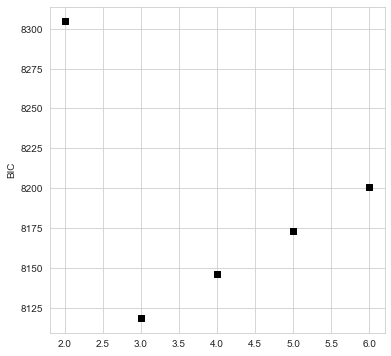

In [21]:
plt.figure(figsize=(6,6))

# insert your code here
x_v = range(min_cluster,max_cluster+1)
y_v = np.array([np.min(res_dic['%02d'%i]['bic']) for i in range(min_cluster,max_cluster+1)])
plt.grid(True)
plt.scatter(x_v, y_v,c='black',marker=',')
plt.ylabel('BIC')

plt.show()


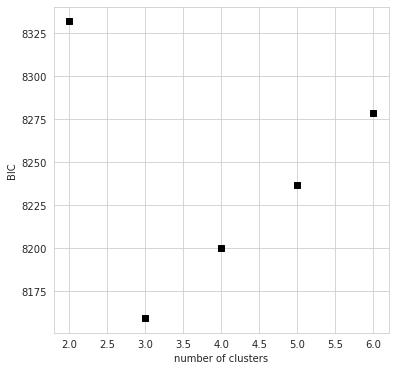

## Task 4: Spike sorting using Mixture of Gaussian 
Run the full algorithm on your set of extracted features (including model complexity selection). Plot the BIC as a function of the number of mixture components on the real data. For the best model, make scatter plots of the first PCs on all four channels (6 plots). Color-code each data point according to its class label in the model with the optimal number of clusters. In addition, indicate the position (mean) of the clusters in your plot. 

*Grading: 3 pts*


In [31]:
# --------------------------------------------------------------------------
# Select the model that best represents the data according to the BIC (1 pt)
# --------------------------------------------------------------------------
min_cluster = 3
max_cluster = 18
num_iter = 10

start_time = time.time()

trueD_res_dic = {}
i=min_cluster
while i<(max_cluster+1):
    trueD_res_dic['%02d'%i] = split_and_merge(b, i, num_iter)
    con_1 = (trueD_res_dic['%02d'%i]['split']==False)
    con_2 = (trueD_res_dic['%02d'%i]['merge']==True)
    print('split>%02d clusters? %s'%(i,con_1))
    print('merge<%02d clusters? %s'%(i,con_2))
    i = i+1
    if con_1 and con_2: break
    
print("--- %s seconds ---" % (time.time() - start_time))

split>03 clusters? False
merge<03 clusters? False
split>04 clusters? False
merge<04 clusters? False
split>05 clusters? False
merge<05 clusters? False
split>06 clusters? False
merge<06 clusters? False
split>07 clusters? False
merge<07 clusters? True
split>08 clusters? False
merge<08 clusters? True
split>09 clusters? False
merge<09 clusters? True
split>10 clusters? False
merge<10 clusters? False
split>11 clusters? False
merge<11 clusters? True
split>12 clusters? False
merge<12 clusters? True
split>13 clusters? False
merge<13 clusters? True
split>14 clusters? False
merge<14 clusters? True
split>15 clusters? False
merge<15 clusters? True
split>16 clusters? False
merge<16 clusters? True
split>17 clusters? False
merge<17 clusters? True
split>18 clusters? True
merge<18 clusters? True
--- 465.61524772644043 seconds ---


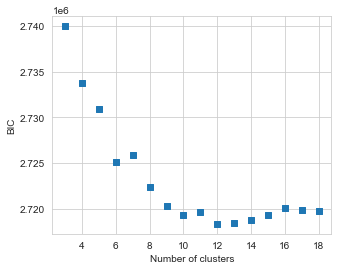

In [32]:
plt.figure(figsize=(5, 4))
min_cluster = 3

# insert your code here
x_v = [min_cluster+i for i in range(len(trueD_res_dic))]
y_v = np.array([np.min(trueD_res_dic['%02d'%(min_cluster+i)]['bic']) for i in range(len(trueD_res_dic))])
plt.grid(True)
plt.scatter(x_v, y_v,marker=',')
plt.ylabel('BIC')
plt.xlabel('Number of clusters')
plt.show()

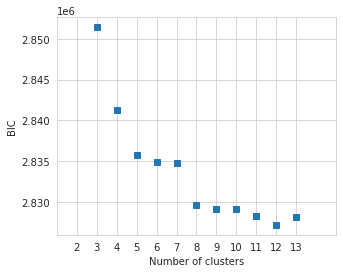

Refit model with lowest BIC and plot data points

In [33]:
# insert your code here
num_cluster = min_cluster+np.argmin(y_v)
print('lowest BIC reached at %02d clusters'%num_cluster)
ind = np.argmin(trueD_res_dic['%02d'%(num_cluster)]['bic'])
mog_labels = trueD_res_dic['%02d'%(num_cluster)]['mog_labels'][ind].astype(int)
m = trueD_res_dic['%02d'%(num_cluster)]['m'][ind]

lowest BIC reached at 12 clusters


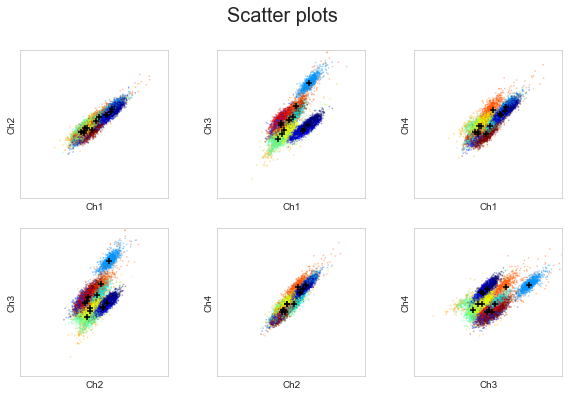

In [35]:
# -------------------------------------------------------------------------------------
# Create scatterplots of the first PCs under the best model for all 4 channels. (2 pts)
# -------------------------------------------------------------------------------------

colors = plt.cm.jet(np.linspace(0,1,max(mog_labels)+1))

plt.figure(figsize=(10, 6))
plt.suptitle('Scatter plots',fontsize=20)

# insert your code here

n_feature = 3

p=1

labels = ['Ch1','Ch2','Ch3','Ch4']
for i in np.arange(0,4):
    for j in np.arange(i+1,4):
        ax = plt.subplot(2,3, p, aspect='equal')
        plt.scatter(b[:,n_feature*i],b[:,n_feature*j],s=.5,c=colors[mog_labels,:],alpha=.3) 
        plt.scatter(m[:,n_feature*i],m[:,n_feature*j],marker = '+', s=30,color='black')
        plt.xlabel(labels[i])
        plt.ylabel(labels[j])
        plt.xlim((-1500,1500))
        plt.ylim((-1500,1500))
        ax.set_xticks([])
        ax.set_yticks([])
        p+=1


plt.show()

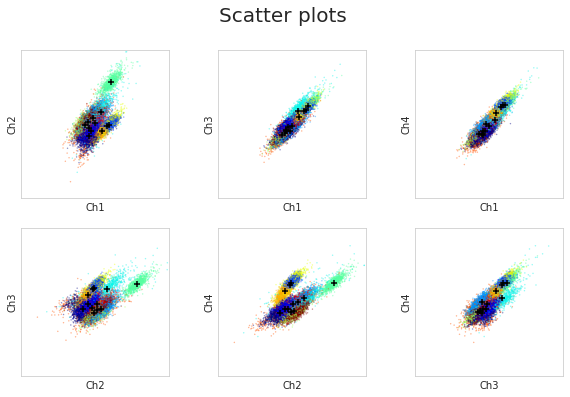

In [37]:
np.save('../data/nda_ex_2_means',m)
np.save('../data/nda_ex_2_covs',S)
np.save('../data/nda_ex_2_pis',p)
np.save('../data/nda_ex_2_labels',mog_labels)